In [28]:
import os
import sys
from pathlib import Path
import pytorch_lightning as pl
import torch
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from torch_geometric.datasets import WikiCS

In [29]:
sys.path.append(str(Path(os.getcwd()).resolve().parent))
from src.gmm import GaussianMixtureModel, GMMDataModule, get_gmm_trainer

In [30]:
dataset_path = Path(os.getcwd()).resolve().parent / "data" / "WikiCS"
dataset = WikiCS(root=dataset_path)
original_data = dataset[0]
original_data.x.shape

/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/torch_geometric/datasets/wikics.py:45: UserWarning: The WikiCS dataset now returns an undirected graph by default. Please explicitly specify 'is_undirected=False' to restore the old behavior.
  warnings.warn(


torch.Size([11701, 300])

In [31]:
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import rand_score

def predict(model, x: torch.Tensor) -> np.ndarray:
    return torch.argmax(model.gamma_top(x), dim=0).numpy()

def purity_score(labels_true, labels_pred) -> float:
    mx = contingency_matrix(labels_true=labels_true, labels_pred=labels_pred)
    return np.sum(np.max(mx, axis=0)) / len(labels_pred)

In [32]:
ACCELERATOR='gpu'

In [33]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix
import pandas as pd

def visualise_clustering(node_features, node_embeddings, y_true, y_pred, viz_p: float, viz_seed: int = 0, name: str = ''):
    f_pca = PCA(n_components=2)
    f_2d = StandardScaler().fit_transform(node_features)
    f_2d = f_pca.fit_transform(f_2d)

    e_pca = PCA(n_components=2)
    e_2d = StandardScaler().fit_transform(node_embeddings)
    e_2d = e_pca.fit_transform(e_2d)

    rng = np.random.default_rng(seed=viz_seed)
    indexes = rng.choice(node_embeddings.shape[0], size=int(node_embeddings.shape[0] * viz_p), replace=False)
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    # true classes
    df_f_pca = pd.DataFrame({'PCA1': f_2d[:, 0][indexes], 'PCA2': f_2d[:, 1][indexes], 'label': y_true[indexes]})
    df_e_pca = pd.DataFrame({'PCA1': e_2d[:, 0][indexes], 'PCA2': e_2d[:, 1][indexes], 'label': y_true[indexes]})
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_f_pca, palette='tab10', alpha=0.8, ax=ax[0, 0])
    ax[0, 0].set_title(f"Node features (true classes) (explained variance: {f_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_e_pca, palette='tab10', alpha=0.8, ax=ax[0, 1])
    ax[0, 1].set_title(f"Node embedings (true classes) (explained variance: {e_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    # clusters
    df_f_pca = pd.DataFrame({'PCA1': f_2d[:, 0][indexes], 'PCA2': f_2d[:, 1][indexes], 'label': y_pred[indexes]})
    df_e_pca = pd.DataFrame({'PCA1': e_2d[:, 0][indexes], 'PCA2': e_2d[:, 1][indexes], 'label': y_pred[indexes]})
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_f_pca, palette='tab10', alpha=0.8, ax=ax[1, 0])
    ax[1, 0].set_title(f"Node features (clusters) (explained variance: {f_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    sns.scatterplot(x='PCA1', y='PCA2', hue='label', data=df_e_pca, palette='tab10', alpha=0.8, ax=ax[1, 1])
    ax[1, 1].set_title(f"Node embedings (clusters) (explained variance: {e_pca.explained_variance_ratio_.cumsum()[-1] * 100:.3f}%)")
    
    fig.suptitle(name)
    fig.tight_layout()
    plt.show()

def post_hoc_assignment(y_true, y_pred, ax=None):
    cm = confusion_matrix(y_true, y_pred)    
    mapping = cm.argmax(axis=0)
    if not ax is None:
        sns.heatmap(cm, annot=True, fmt='d', ax=ax)
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Post Hoc Assignment Matrix')
    return mapping, cm

def post_hoc_assignment_visualise(y_true, y_pred, ax, name:str):
    mapping, cm = post_hoc_assignment(y_true, y_pred, ax)
    unique_values, counts = np.unique(mapping, return_counts=True)
    textss = [f"{v}({c})" for v, c in zip(unique_values, counts)]
    text = " ".join(textss)
    ax.set_title(f"Post Hoc Assignment Matrix {name} (true class (#clusters): {text})")
        

def experiment_diy(node_embeddings, original_data, seeds: list[int]):
    results_clustering = []
    y_preds = []
    for seed in seeds:
        torch.manual_seed(seed)
        model = GaussianMixtureModel(n_components=10, dim=node_embeddings.shape[1])
        datamodule = GMMDataModule(node_embeddings)
        trainer = get_gmm_trainer('gmm', max_epochs=50, termination_threshold=1e-3, accelerator=ACCELERATOR, patience=2, verbose=False)
        trainer.fit(model, datamodule=datamodule)
        y_pred = predict(model, node_embeddings)
        results_clustering.append({
            'purity_score': purity_score(original_data.y, y_pred),
            'rand_score': rand_score(original_data.y, y_pred)
        })
        y_preds.append(y_pred)
    df = pd.DataFrame(results_clustering)
    max_it = df['rand_score'].argmax()
    return df, y_preds[max_it]
    

def experiment_sklearn(model_class, model_args: dict, node_embeddings, original_data, seeds: list[int]):
    results_clustering = []
    y_preds = []
    for seed in seeds:
        model = model_class(**model_args, random_state=seed)
        y_pred = model.fit_predict(node_embeddings)
        results_clustering.append({
            'purity_score': purity_score(original_data.y, y_pred),
            'rand_score': rand_score(original_data.y, y_pred)
        })
        y_preds.append(y_pred)
    df = pd.DataFrame(results_clustering)
    max_it = df['rand_score'].argmax()
    return df, y_preds[max_it]

def full_experiment(node_embeddings, original_data):
    seeds = [0]#[0, 11, 18, 52, 100]
    diy_df, diy_best_pred = experiment_diy(node_embeddings, original_data, seeds)
    gm_df, gm_best_pred = experiment_sklearn(
        GaussianMixture, 
        {'n_components': 10, 'init_params': 'random'},
        node_embeddings.numpy(),
        original_data,
        seeds
    )
    km_df, km_best_pred = experiment_sklearn(
        KMeans, 
        {'n_clusters': 10, 'init': 'random'},
        node_embeddings.numpy(),
        original_data,
        seeds
    )
    diy_df['model'] = 'diy_gausian_mixture'
    gm_df['model'] = 'sklearn_gausian_mixture'
    km_df['model'] = 'sklearn_kmeans'
    df = pd.concat([diy_df, gm_df, km_df], ignore_index=True)
    result = df.groupby('model').agg(['mean', 'std'])[['purity_score', 'rand_score']]
    print(result)
    fig, ax = plt.subplots(3, 1, figsize=(8, 12))
    post_hoc_assignment_visualise(original_data.y, diy_best_pred, ax[0], 'MyGaussian')
    post_hoc_assignment_visualise(original_data.y, gm_best_pred, ax[1], 'GaussianMixture')
    post_hoc_assignment_visualise(original_data.y, km_best_pred, ax[2], 'KMeans')
    fig.tight_layout()
    plt.show()
    visualise_clustering(
        original_data.x, node_embeddings.numpy(),
        original_data.y, diy_best_pred, viz_p=0.2,
        viz_seed=seeds[0], name='MyGaussian'
    )
    visualise_clustering(
        original_data.x, node_embeddings.numpy(),
        original_data.y, gm_best_pred, viz_p=0.2,
        viz_seed=seeds[0], name='GaussianMixture'
    )
    visualise_clustering(
        original_data.x, node_embeddings.numpy(),
        original_data.y, km_best_pred, viz_p=0.2,
        viz_seed=seeds[0], name='KMeans'
    )
    
    

# Embedingi dim=4

## GATE enkoder

In [34]:
embedings_path = Path(os.getcwd()).resolve().parent / "data" / "embeddings" / "node_embeddings_gca_gate_4_1.0.pt"
with open(embedings_path, 'rb') as f:
    node_embedings = torch.load(f)

/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
/home/witcher/jakub/ure/representation_clustering/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


                        purity_score     rand_score    
                                mean std       mean std
model                                                  
diy_gausian_mixture         0.448509 NaN   0.770495 NaN
sklearn_gausian_mixture     0.456628 NaN   0.784378 NaN
sklearn_kmeans              0.472267 NaN   0.805473 NaN


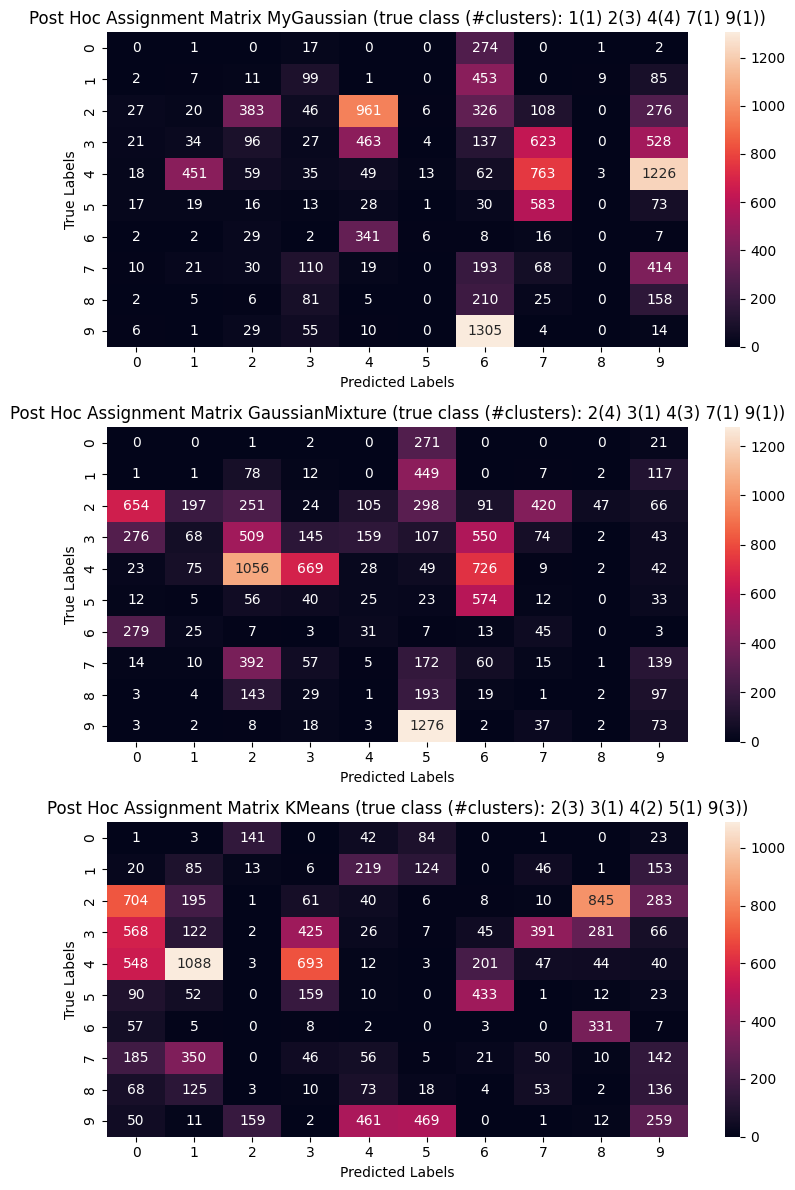

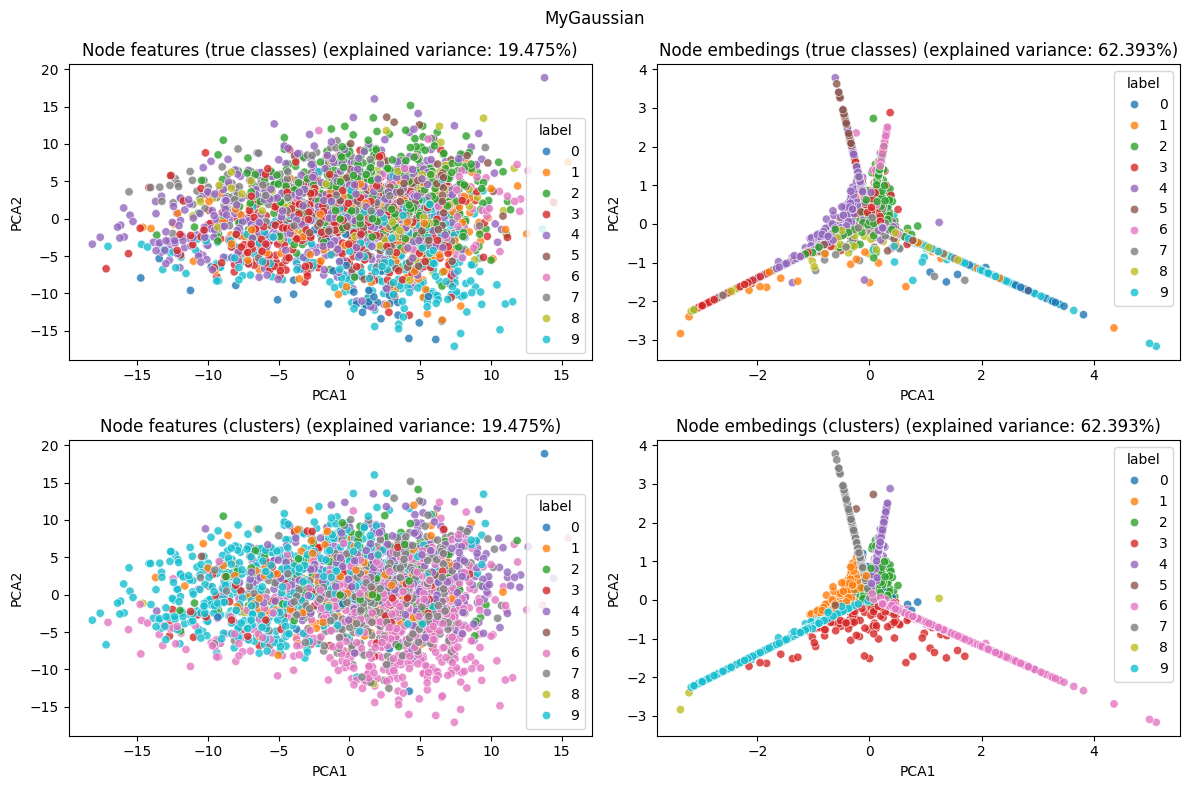

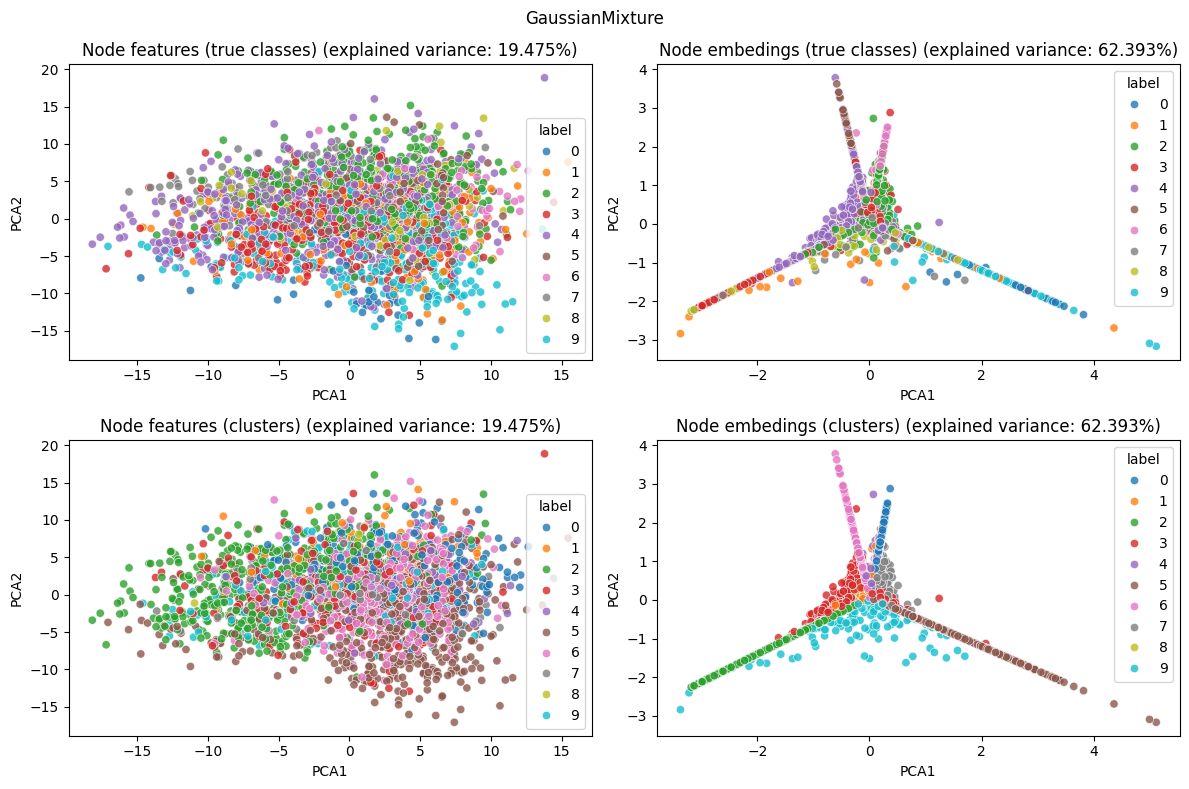

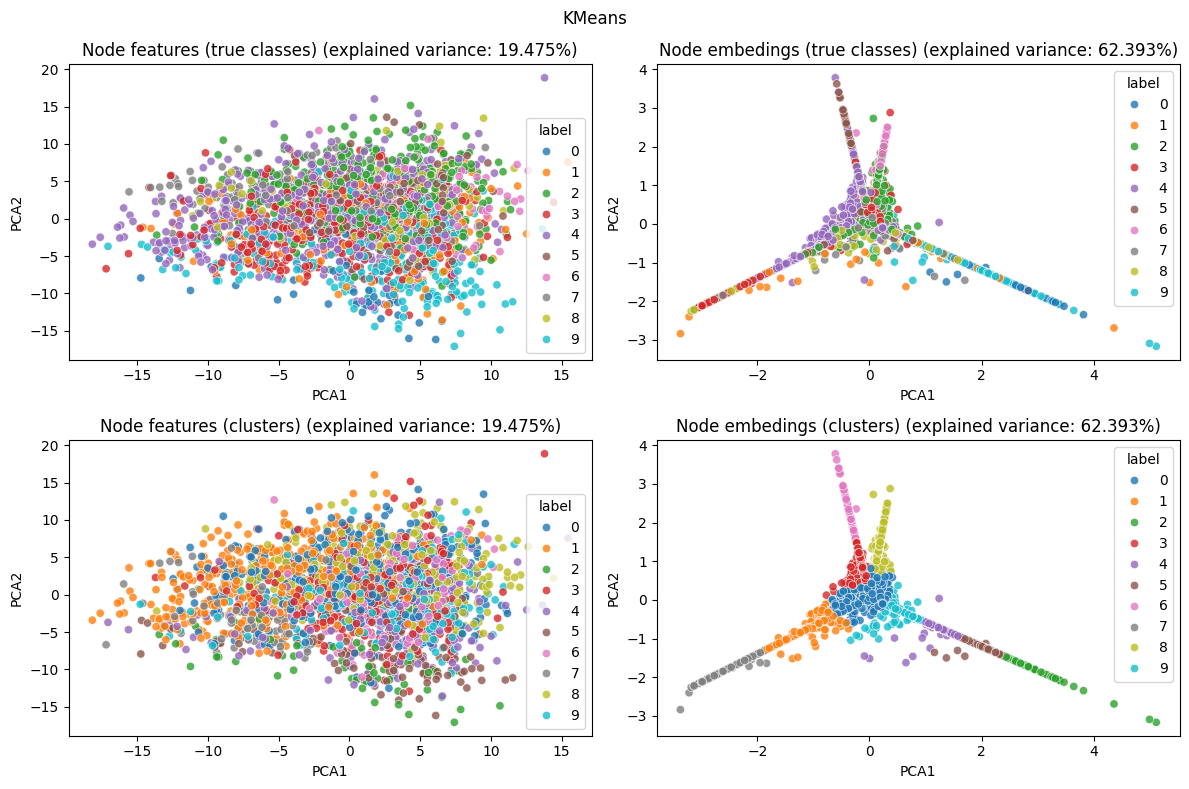

In [35]:
full_experiment(node_embedings, original_data)